In [1]:
import numpy as np
%pylab inline

Populating the interactive namespace from numpy and matplotlib


Text(0, 0.5, 'o2')

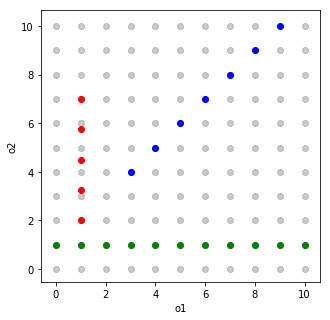

In [199]:
X = np.mgrid[0:10:11j,0:10:11j]
X = np.einsum('abc->bca',X).reshape(11**2,2)
plt.scatter(X[:,0],X[:,1], alpha = 0.2, c = 'k')



o1 = np.linspace(0,10,11)
o2 = np.ones_like(o1)*1

chan1 = np.concatenate([o1.reshape(-1,1),o2.reshape(-1,1)],axis=1)
plt.scatter(chan1[:,0],chan1[:,1], c = 'g')


o1 = np.linspace(3,9,7)
o2 = o1+1

chan2 = np.concatenate([o1.reshape(-1,1),o2.reshape(-1,1)],axis=1)
plt.scatter(chan2[:,0],chan2[:,1], c = 'b')

o1 = np.ones(5,)*1
o2 = np.linspace(2,7,5)
chan3 = np.concatenate([o1.reshape(-1,1),o2.reshape(-1,1)],axis=1)
plt.scatter(chan3[:,0],chan3[:,1], c = 'r')

plt.gcf().set_size_inches(5,5)
plt.xlabel('o1')
plt.ylabel('o2')

In [200]:
observX = np.concatenate([chan1,chan2,chan3])

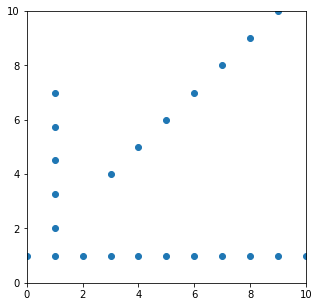

In [201]:
plt.scatter(observX[:,0],observX[:,1])
plt.xlim(0,10)
plt.ylim(0,10)
plt.gcf().set_size_inches(5,5)

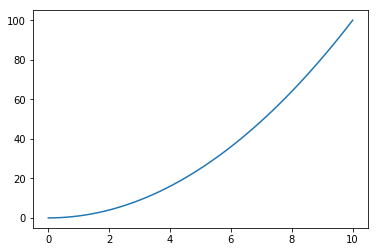

In [202]:
x = np.linspace(0,10)
y = x**2
plt.plot(x,y)

In [203]:
def truth(X,alphas):
    al0, al1 = alphas[:,0], alphas[:,1]
    x0,x1 = X[:,0], X[:,1]

    norm1 = 1.5-al1
    norm2 = 3.0-norm1
    f0 = 3-al0
    f1 = 3-al1
    len0 = 5*f0
    len1 = 7*f1
    
    return 20 * (norm1 * np.exp(-x0/len0) + norm2 * np.exp(-x1/len1))

In [204]:
np.sign(-1)

-1

In [205]:
# np.random.randint(len())
# observX

In [206]:
global_chan_numbers = np.arange(len(observX))
print(global_chan_numbers)

ind = [0] + np.cumsum([len(chan1),len(chan2),len(chan3)]).tolist()
sli = [slice(ind[i],ind[i+1]) for i in range(len(ind)-1)]


meas_chan = [0,1,2]

chan_datas = []
for chan_num in meas_chan:
    global_chan_numbers[sli[1]]
    n_evals = 20
    bin_nums  = np.random.choice(global_chan_numbers[sli[chan_num]], size = n_evals)
    alphas    = np.random.uniform(-1.3,1.3, size = (n_evals,2))
    chan_data = np.concatenate([bin_nums.reshape(-1,1),alphas], axis=1)
    chan_datas.append(chan_data)


[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22]


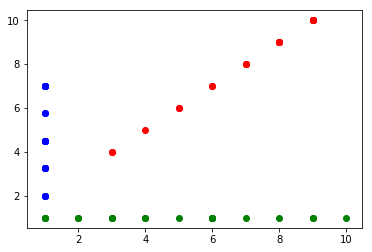

In [207]:
this = observX[np.asarray(chan_datas[0][:,0], dtype='int')]
plt.scatter(this[:,0],this[:,1], c = 'g')


this = observX[np.asarray(chan_datas[1][:,0], dtype='int')]
plt.scatter(this[:,0],this[:,1], c = 'r')

this = observX[np.asarray(chan_datas[2][:,0], dtype='int')]
plt.scatter(this[:,0],this[:,1], c = 'b')

In [208]:
from sklearn.gaussian_process.kernels import RBF
from sklearn.gaussian_process.kernels import ConstantKernel
from sklearn.gaussian_process.kernels import WhiteKernel
from sklearn.gaussian_process.kernels import Matern
from sklearn.gaussian_process.kernels import RationalQuadratic
from sklearn.gaussian_process import GaussianProcessRegressor

def get_gp(X, y, alpha=10**-3, kernel_name='const_rbf', seed = 1234):
    kernel = ConstantKernel(
#             constant_value_bounds=[1.,100.0]
            ) * Matern(
                length_scale_bounds=[2.,10.], length_scale = [10.,10.,1.,1.],
            ) + WhiteKernel(noise_level_bounds=[1.,3.]
#                 constant_value_bounds=[0,0.001]
#             ) * Matern(
#                 length_scale_bounds=[.001,100]
            )
    gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10, alpha=alpha, random_state=seed)
    gp.fit(X, y.ravel())
    return gp
# ConstantKernel?

In [209]:
for_gp = []
for nchan in meas_chan:
    thisX = observX[np.asarray(chan_datas[nchan][:,0], dtype='int')]
    thisA = chan_datas[0][:,1:]
    v = truth(thisX,thisA)
    full_chan_data = np.concatenate([chan_datas[nchan],v.reshape(-1,1)],axis=1)
    all_in_one = np.concatenate([observX[np.asarray(full_chan_data[:,0],dtype='int')],full_chan_data[:,1:]],axis=1)
    for_gp.append(all_in_one)
for_gp = np.concatenate(for_gp)
# len(for_gp),len(observX)
# for_gp[0].shape
for_gp.shape

(60, 5)

In [210]:
# full_chan_data = np.concatenate([chan_datas[1],v.reshape(-1,1)],axis=1)
# thisX = observX[np.asarray(chan_datas[0][:,0], dtype='int')]
# thisA = chan_datas[0][:,1:]
# v = truth(thisX,thisA)

# np.random.choice(obvervX)


# for_gp = np.concatenate([observX[np.asarray(full_chan_data[:,0],dtype='int')],full_chan_data[:,1:]],axis=1)
for_gp_X = for_gp[:,:4]
for_gp_y = for_gp[:,4]
gp = get_gp(for_gp_X,for_gp_y)

In [211]:
def plot(a0,a1):
    alphas = [a0,a1]

    f,axarr = plt.subplots(1,3)

    f.set_size_inches(15,5)

    
    vmin,vmax = 40,60 
    
    ax = axarr[0]
    X = np.mgrid[0:10:31j,0:10:31j]
    evalX = np.einsum('abc->bca',X).reshape(31**2,2)
    evalA = np.einsum('x,a->xa',np.ones((len(evalX),)),alphas)
    ax.scatter(evalX[:,0],evalX[:,1], c = truth(evalX,evalA), vmin = vmin,vmax = vmax)
    ax.set_ylim(0,10)
    ax.set_xlim(0,10)
    
#     evalX  = observX[global_chan_numbers]
#     evalA = np.einsum('x,a->xa',np.ones((len(evalX),)),alphas)
    w,werr = gp.predict(np.concatenate([evalX,evalA],axis=1), return_std = True)
    
    
    ax = axarr[1]
    ax.set_xlim(0,10)
    ax.set_ylim(0,10)
    ax.scatter(evalX[:,0],evalX[:,1], c = w, vmin = vmin,vmax = vmax)


    evalX  = observX[global_chan_numbers]
    evalA = np.einsum('x,a->xa',np.ones((len(evalX),)),alphas)

    ax.scatter(evalX[:,0],evalX[:,1], c = 'r')


    w,werr = gp.predict(np.concatenate([evalX,evalA],axis=1), return_std = True)
    t = truth(evalX,evalA)
    
    ax = axarr[2]
    for sl in sli:
        bin_num = global_chan_numbers[sl]
        ch_y = w[sl]
        ch_t = t[sl]
        y_m_err = (w-werr)[sl]
        y_p_err = (w+werr)[sl]
        ax.fill_between(bin_num,y_m_err,y_p_err, facecolor = 'grey', alpha = 0.2)
        ax.scatter(bin_num,ch_y)
        ax.plot(bin_num,ch_y)
        ax.plot(bin_num,ch_t, c = 'k', linestyle = 'dotted', alpha = 0.5)
    ax.set_ylim(0,1.2*vmax)

In [212]:
from ipywidgets import interact
interact(plot, a0 = (-1,1,0.1), a1 = (-1,1,0.1))

interactive(children=(FloatSlider(value=0.0, description='a0', max=1.0, min=-1.0), FloatSlider(value=0.0, desc…

<function __main__.plot(a0, a1)>

In [177]:
Matern?